# Teoria da Decisão - ELE088

*Prof. Lucas S. Batista*  
*Departamento de Engenharia Elétrica*  
*Universidade Federal de Minas Gerais*

# Estudo de Caso

## Problema de Designação Generalizada:

- Considere que existam $n$ tarefas e $m$ agentes ($n > m$), de tal forma que cada tarefa deve ser atribuída a um único agente. A execução da tarefa $j$ pelo agente $i$ tem um custo $c_{ij}$ e demanda uma quantidade de recursos $a_{ij}$ . Cada agente $i$ tem uma disponibilidade de recursos $b_i$. Formule um problema que atribua as tarefas de forma a minimizar o custo total de execução sem exceder os recursos dos agentes.

## Modelagem do problema

Assumindo que $x_{ij}$ represente as variáveis de otimização do problema, pode-se definir que se $x_{ij} = 1$, então a tarefa $j$ é atribuída ao agente $i$; caso contrário, i.e., se $x_{ij} = 0$, então a tarefa $j$ não é atribuída ao agente $i$.

Com o intúito de minimizar o custo total de execução de todas as tarefas, pode-se escrever a seguinte função objetivo:

$$ \min_x \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij} $$

Adicionalmente, este problema apresenta o seguinte conjunto de restrições:

\begin{align} 
\sum_{i=1}^{n} x_{ij} = 1, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R1) \\
\sum_{j=1}^{n} a_{ij} x_{ij} \leq b_i, \forall i \in \{1, \ldots, n\} \hspace{2cm} (R2) \\
x_{ij} \in \{0, 1\}, \forall i \in \{1, \ldots, n\}, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R3)
\end{align}

em que **R1** assegura que cada tarefa $j$ será realizada por um único agente $i$; **R2** assegura que cada agente $i$ terá seus recursos respeitados; e **R3** define o domínio das variáveis de decisão $x_{ij}$.

## Otimização de uma instância arbitrária do problema via RVNS

A seguir são apresentados os trechos de código da implementação do RVNS para o estudo de caso apresentado.

In [1]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy

'''
Define um tipo de dado similar ao Pascal "record" or C "struct"
'''
class Struct:
    pass

Os dados da instância teste são definidos a seguir. Note que considera-se um número *default* de $m = 5$ agentes e $n = 25$ tarefas. Além disso, assume-se uma matriz de custos e uma matriz de recursos em que os custos/recursos de execução das tarefas $t_1, t_2, \ldots, t_j, \ldots, t_n$ pelo $i$-ésimo agente são apresentados ao longo da $i$-ésima linha. A disponibilidade de recursos do $i$-ésimo agente é acessada em $b_i$.

In [2]:
'''
Define os dados de uma instância arbitrária do problema
'''
def probdef(m=5, n=25):
    
    # m: número de agentes considerados
    # n: número de tarefas consideradas
        
    '''
    Custo: [  t1 t2 ... tj ... tn
            a1
            a2
            ...
            ai
            ...
            am                    ]
    
    Recurso: [  t1 t2 ... tj ... tn
              a1
              a2
              ...
              ai
              ...
              am                    ]
    
    Recursos disponíveis:    
    b = [b1 b2 ... bm]
    
    '''    
    
    np.random.seed(13)
    custo   = np.random.randint(10,50,size=(m,n)) # considera custos inteiros aleatórios no conjunto {10, 11, ..., 49}
    recurso = np.random.randint(10,50,size=(m,n)) # considera recursos inteiros aleatórios no conjunto {10, 11, ..., 49}
    b = 0.25*recurso.sum(axis=1) # recurso do agente i igual a 25% do recurso de atribuir todas as tarefas ao agente i   
    np.random.seed()
    
    probdata = Struct()
    probdata.m = m
    probdata.n = n
    probdata.custo = custo
    probdata.recurso = recurso
    probdata.b = b
    
    return probdata

Uma solução candidata $x$ para o problema foi modelada computacionalmente como uma lista de tarefas atribuídas, respectivamente, aos agentes $a_1, a_2, ... a_i, ..., a_n$.

In [3]:
'''
Implementa a função objetivo do problema
'''
def sol_inicial(probdata):
    
    '''  
    Modelou-se uma solução x como uma lista de tarefas atribuídas, respectivamente, aos agentes a1, a2, ... ai, ..., am
    
                a1            a2     ...     am
    x = [ [t7 t3 ... t9] [t4 ... t2] ... [t5 ... t8] ]
    '''
                
    x = Struct()
    x.solution = list()    
    for count in np.arange(0,probdata.m,1):                       # cria uma lista de listas vazias
        x.solution.append([])
    
    list_of_jobs = np.random.permutation(probdata.n)
    for tarefa in list_of_jobs:                                   # aloca tarefas aleatoriamente aos agentes
        x.solution[np.random.randint(probdata.m)].append(tarefa) 
        
    return x

A função objetivo é implementada conforme a definição apresentada anteriormente. De forma geral, dada uma solução $x$, que indica a distribuição de tarefas a agentes, esta função computa o somatório dos custos relacionados.

In [4]:
'''
Implementa a função objetivo do problema
'''
def fobj(x, probdata):
    
    '''  
                a1            a2     ...     am
    x = [ [t7 t3 ... t9] [t4 ... t2] ... [t5 ... t8] ]
    '''
    
    fit = [] # armazena o custo de cada agente i
    g   = [] # armazena o valor da restrição R2 para cada agente i
    for i in np.arange(0,probdata.m,1):
        fit_i = 0.0
        recurso_i = 0.0
        for j in np.arange(0,len(x.solution[i]),1):            
            fit_i += probdata.custo[i,x.solution[i][j]]       # somatório dos custos do i-ésimo agente            
            recurso_i += probdata.recurso[i,x.solution[i][j]] # somatório dos recursos consumidos pelo i-ésimo agente
        
        fit.append(fit_i)                    
        g.append(recurso_i - probdata.b[i])  
        
    fit = np.array(fit)
    g   = np.array(g)
    
    x.fitness = fit.sum()                                 # custo total da solução candidata x
    x.penalidade = 100*np.sum(np.where(g <= 0, 0, g)**2)  # penalidade aplicada sobre a solução x
    x.fitness_penalizado = x.fitness + x.penalidade       # custo total penalizado da solução x
    
    return x

A função *neighborhoodChange* atualiza a solução corrente e também a estrutura de vizinhança. De forma geral, se a nova solução gerada $y$ apresentar um custo *fitness_y* menor que o da solução incumbente $x$, então a solução incumbente é atualizada e retoma-se a primeira estrutura de vizinhança, i.e., faz-se $k = 1$. Caso contrário, apenas segue-se para a próxima estrutura de vizinhança, mantendo-se a solução corrente $x$.

In [5]:
'''
Implementa a função neighborhoodChange
'''
def neighborhoodChange(x, y, k):
        
    if y.fitness_penalizado < x.fitness_penalizado:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
        
    return x, k

Para o estudo de caso em questão foram propostas três estruturas de vizinhanças:

1. A primeira estrutura de vizinhança realiza a troca de duas tarefas entre agentes (aleatoriamente).
2. A segunda estrutura de vizinhança remove uma tarefa de um agente e a aloca em outro (aleatoriamente).
3. A terceira estrutura de vizinhança desloca uma tarefa de um 1o agente para um 2o, e deste 2o agente para um 3o (aleatoriamente).

In [6]:
'''
Implementa a função shake
'''
def shake(x, k, probdata):
    
    y = copy.deepcopy(x)
    random_agent = np.random.permutation(probdata.m)
    
    if k == 1: # troca duas tarefas entre agentes (aleatoriamente)
        random_job_idx0 = np.random.randint(len(y.solution[random_agent[0]]))            
        random_job0 = y.solution[random_agent[0]].pop(random_job_idx0)
        
        random_job_idx1 = np.random.randint(len(y.solution[random_agent[1]]))
        random_job1 = y.solution[random_agent[1]].pop(random_job_idx1)
        
        y.solution[random_agent[0]].append(random_job1)
        y.solution[random_agent[1]].append(random_job0)
        
    elif k == 2: # remove uma tarefa de um agente e a aloca em outro (aleatoriamente)              
        random_job_idx = np.random.randint(len(y.solution[random_agent[0]]))    
        random_job = y.solution[random_agent[0]].pop(random_job_idx)        
        y.solution[random_agent[1]].append(random_job)
        
    elif k == 3: # desloca uma tarefa de um 1o agente para um 2o, e deste 2o agente para um 3o (aleatoriamente)
        random_job_idx0 = np.random.randint(len(y.solution[random_agent[0]]))        
        random_job0 = y.solution[random_agent[0]].pop(random_job_idx0)  
        
        random_job_idx1 = np.random.randint(len(y.solution[random_agent[1]]))
        random_job1 = y.solution[random_agent[1]].pop(random_job_idx1)
        
        y.solution[random_agent[2]].append(random_job1)
        y.solution[random_agent[1]].append(random_job0)
    
    return y

### Estrutura principal do método RVNS


--- SOLUÇÃO INICIAL CONSTRUÍDA ---

Sequência de tarefas atribuídas aos agentes:

x = [[21, 18, 22, 0, 6, 15], [20, 17, 23, 7, 16], [24, 4], [14, 2, 13, 3, 9], [5, 12, 19, 10, 11, 1, 8]]

fitness(x) = 737.00

fitness(x) penalizado = 8837.00

penalidade(x) = 8100.00


--- MELHOR SOLUÇÃO ENCONTRADA ---

Sequência de tarefas atribuídas aos agentes:

x = [[22, 23, 8, 14, 1], [18, 24, 7, 13], [12, 9, 15, 10, 0, 21], [2, 6, 20, 11, 3], [19, 16, 4, 5, 17]]

fitness(x) = 419.00

fitness(x) penalizado = 419.00

penalidade(x) = 0.00



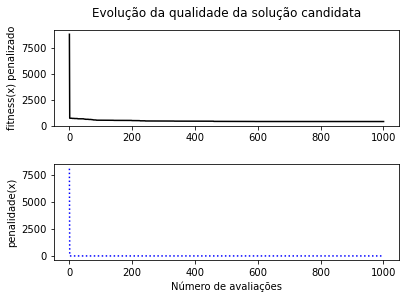

In [7]:
'''
Implementa uma metaheurística RVNS
'''

# Contador do número de soluções candidatas avaliadas
num_sol_avaliadas = 0

# Máximo número de soluções candidatas avaliadas
max_num_sol_avaliadas = 1000

# Número de estruturas de vizinhanças definidas
kmax = 3

# Faz a leitura dos dados da instância do problema
probdata = probdef(m=5,n=25)

# Gera solução inicial
x = sol_inicial(probdata)

# Avalia solução inicial gerada
x = fobj(x,probdata)
num_sol_avaliadas += 1

# Armazena dados para plot
historico = Struct()
historico.fit = []
historico.sol = []
historico.pen = []
historico.fit_pen = []
historico.fit.append(x.fitness)
historico.sol.append(x.solution)
historico.pen.append(x.penalidade)
historico.fit_pen.append(x.fitness_penalizado)


# Ciclo iterativo do método
while num_sol_avaliadas < max_num_sol_avaliadas:
    
    k = 1
    while k <= kmax:
        
        # Gera uma solução candidata na k-ésima vizinhança de x          
        y = shake(x,k,probdata)
        y = fobj(y,probdata)
        num_sol_avaliadas += 1
        
        # Atualiza solução corrente e estrutura de vizinhança (se necessário)
        x, k = neighborhoodChange(x, y, k)
        
        # Armazena dados para plot
        historico.fit.append(x.fitness)
        historico.sol.append(x.solution)
        historico.pen.append(x.penalidade)
        historico.fit_pen.append(x.fitness_penalizado)
        

print('\n--- SOLUÇÃO INICIAL CONSTRUÍDA ---\n')
print('Sequência de tarefas atribuídas aos agentes:\n')
print('x = {}\n'.format(historico.sol[0]))
print('fitness(x) = {:.2f}\n'.format(historico.fit[0]))
print('fitness(x) penalizado = {:.2f}\n'.format(historico.fit_pen[0]))
print('penalidade(x) = {:.2f}\n'.format(historico.pen[0]))

print('\n--- MELHOR SOLUÇÃO ENCONTRADA ---\n')
print('Sequência de tarefas atribuídas aos agentes:\n')
print('x = {}\n'.format(x.solution))
print('fitness(x) = {:.2f}\n'.format(x.fitness))
print('fitness(x) penalizado = {:.2f}\n'.format(x.fitness_penalizado))
print('penalidade(x) = {:.2f}\n'.format(x.penalidade))

fig, (ax1, ax2) = plt.subplots(2, 1)
s = len(historico.fit_pen)
ax1.plot(np.linspace(0,s-1,s),historico.fit_pen,'k-')
ax2.plot(np.linspace(0,s-1,s),historico.pen,'b:')
fig.suptitle('Evolução da qualidade da solução candidata')
ax1.set_ylabel('fitness(x) penalizado')
ax2.set_ylabel('penalidade(x)')
ax2.set_xlabel('Número de avaliações')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()